In [1]:
from rostering_solver import Instance, Solver
import pandas as pd
import numpy as np
import json
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
city = 'berlin'
demand_baseline = "1.00"
demand_type = "doublepeak" # "fixed" "doublepeak"
outsourcing_cost_multiplier = 1.5
model = "flex" # "fixed" # "flex"

read_instance_file = False

In [3]:
if read_instance_file:
    demand_file = f'{city}_db={demand_baseline}_dt={demand_type}.csv'
    print(demand_file)

    demand_df = pd.read_csv(demand_file, index_col=0)
    demand_df['area_id'] = demand_df['area_id'].astype(str) 
    days_ = []
    for i in range(7):
        days_.append([i, "1.00", "uniform"])
    days = pd.DataFrame(days_, columns=['day', 'demand_baseline', 'demand_type']) 
else:
    # Generate instance file
    # Generate several days instances 
    days = pd.DataFrame([
        [0, "1.00", "doublepeak"], # Monday
        [1, "1.00", "doublepeak"], # Tuesday
        [2, "1.00", "doublepeak"], # Wednesday
        [3, "1.00", "doublepeak"], # Thursday
        [4, "1.00", "doublepeak"], # Friday
        [5, "1.00", "doublepeak"], # Satuday
        [6, "1.00", "doublepeak"], # Sunday
    ], columns=['day', 'demand_baseline', 'demand_type']
    )

    demand = []
    area_region_map = None

    for i, row in days.iterrows():
        demand_baseline, demand_type = row['demand_baseline'], row['demand_type']
        key = f'{city}_db={demand_baseline}_dt={demand_type}'

        instance_file = f'../instances/{city}_db={demand_baseline}_dt={demand_type}.json'
        with open(instance_file, 'r') as file:
            instance_data = json.load(file)

        if area_region_map is None:
            regions = instance_data['geography']['city']['regions']
            area_region_map = {}
            for region in regions:
                areas = region['areas'] 
                for area in areas:
                    area_region_map[area['id']] = region['id']
        
        scenario = random.randint(0, instance_data['num_scenarios']-1)
        data_ = (
            pd.DataFrame(instance_data['scenarios'][scenario]['data'])
            .assign(
                day = row['day']
            )
        )
        demand.append(data_)

    demand_df = pd.concat(demand)
    # Add region
    demand_df['region_id'] = demand_df['area_id'].map(area_region_map)

    demand_df = demand_df[['day', 'region_id', 'area_id', 'demand', 'required_couriers']]
    #demand_df.to_csv(f'{city}_db={demand_baseline}_dt={demand_type}.csv')

display(demand_df.head(10))

,day,region_id,area_id,demand,required_couriers
0,0,1,10115,"[0, 1, 4, 4, 4, 2, 3, 0]","[0, 1, 1, 1, 1, 1, 1, 0]"
1,0,1,10117,"[0, 0, 1, 6, 1, 2, 2, 0]","[0, 0, 1, 2, 1, 1, 1, 0]"
2,0,1,10119,"[0, 2, 6, 0, 1, 6, 1, 0]","[0, 1, 2, 0, 1, 2, 1, 0]"
3,0,1,10178,"[0, 0, 5, 2, 1, 2, 2, 0]","[0, 0, 1, 1, 1, 1, 1, 0]"
4,0,1,10179,"[0, 4, 3, 3, 3, 4, 1, 0]","[0, 1, 1, 1, 1, 1, 1, 0]"
5,0,2,10243,"[0, 2, 6, 7, 3, 5, 5, 0]","[0, 1, 2, 2, 1, 1, 1, 0]"
6,0,0,10245,"[0, 3, 8, 5, 6, 6, 2, 0]","[0, 1, 2, 1, 2, 2, 1, 0]"
7,0,0,10247,"[0, 5, 11, 3, 11, 5, 1, 0]","[0, 1, 3, 1, 3, 1, 1, 0]"
8,0,0,10249,"[0, 3, 5, 5, 4, 2, 3, 0]","[0, 1, 1, 1, 1, 1, 1, 0]"
9,0,0,10315,"[0, 0, 8, 3, 3, 5, 3, 0]","[0, 0, 2, 1, 1, 1, 1, 0]"


In [4]:
# READ SHIFTS
key = f'{city}_db={demand_baseline}_dt={demand_type}'

shifts_file = f'../shifts/{city}_db={demand_baseline}_dt={demand_type}.json'
with open(shifts_file, 'r') as file:
    shifts_data = json.load(file)

shifts_df = (
    pd.DataFrame(shifts_data).query(f'outsourcing_cost_multiplier == {outsourcing_cost_multiplier} & demand_type == "{demand_type}" & model == "{model}"')
    .query('regional_multiplier == 1.5 & global_multiplier == 0.8')
)

shifts_df.head(10)


,instance_file,city,demand_baseline,demand_type,model,max_n_shifts,outsourcing_cost_multiplier,regional_multiplier,global_multiplier,region,shifts_start,shifts_end
744,berlin_db=1.00_dt=doublepeak.json,berlin,1.0,doublepeak,flex,NaN,1.5,1.5,0.8,0,"{'0': 0, '1': 2}","{'0': 4, '1': 6}"
745,berlin_db=1.00_dt=doublepeak.json,berlin,1.0,doublepeak,flex,NaN,1.5,1.5,0.8,1,"{'0': 0, '1': 2, '2': 4}","{'0': 4, '1': 6, '2': 8}"
746,berlin_db=1.00_dt=doublepeak.json,berlin,1.0,doublepeak,flex,NaN,1.5,1.5,0.8,2,"{'0': 0, '1': 2}","{'0': 4, '1': 6}"
747,berlin_db=1.00_dt=doublepeak.json,berlin,1.0,doublepeak,flex,NaN,1.5,1.5,0.8,3,"{'0': 0, '1': 2, '2': 4}","{'0': 4, '1': 6, '2': 8}"


In [5]:
# INPUT DATA
regions = [0]

period_demands = demand_df.set_index(['area_id', 'day'])['demand'].to_dict()
period_couriers = demand_df.set_index(['area_id', 'day'])['required_couriers'].to_dict()

region_area_map = { k: list(v) for k, v in demand_df.groupby('region_id').agg({'area_id': 'unique'}).to_dict()['area_id'].items()}
area_region_map = {a: i for i, a in enumerate(list(demand_df['area_id'].unique())) }
areas = list(demand_df['area_id'].unique())

shifts_start = shifts_df.set_index('region')['shifts_start'].to_dict()
shifts_end = shifts_df.set_index('region')['shifts_end'].to_dict()

print(shifts_start)
print(shifts_end)

{0: {'0': 0, '1': 2}, 1: {'0': 0, '1': 2, '2': 4}, 2: {'0': 0, '1': 2}, 3: {'0': 0, '1': 2, '2': 4}}
{0: {'0': 4, '1': 6}, 1: {'0': 4, '1': 6, '2': 8}, 2: {'0': 4, '1': 6}, 3: {'0': 4, '1': 6, '2': 8}}


In [6]:
# VALIDATION OF START
r = 0
Theta = [i for i in range(8)]

print('START')
shifts_ = shifts_start[r]
for shift, start in shifts_.items():
    print(shift, ':', start)
    for theta in Theta[:start]:
        print(' ', theta, 'cannot work!')

# VALIDATION OF END
print('END')
shifts_ = shifts_end[r]
for shift, end in shifts_.items():
    print(shift, ':', end)
    for theta in Theta[end+1:]:
        print(' ', theta, 'cannot work!')

START
0 : 0
1 : 2
  0 cannot work!
  1 cannot work!
END
0 : 4
  5 cannot work!
  6 cannot work!
  7 cannot work!
1 : 6
  7 cannot work!


In [7]:
# MODEL 
region_employees = {0: 10, 1: 15, 2: 15, 3:20}
regions = [0]

i = Instance(regions=regions, areas=areas, 
            region_area_map=region_area_map, area_map=area_region_map, 
            period_demands=period_demands, period_couriers=period_couriers,
            region_employees=region_employees, min_hours_worked=6*8, max_hours_worked=6*8, max_unique_starts=2,
            shifts_start=shifts_start, shifts_end=shifts_end)

s = Solver(i)
s.solve()
s.summary_results()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-12


{'regions': [0],
 'n_employees': 60,
 'obj_value': 1200.25,
 'elapsed_time': 3.0653748512268066,
 'status': 2,
 'hiring_costs': 240.0,
 'outsourcing_costs': 960.25,
 'exec_time': 3.107419967651367,
 'n_variables': 202504,
 'n_constraints': 1320,
 'n_nonzeroes': 16810}

# Analysis

In [8]:
# Utilization rate
util_rate = sum([s.k_var[e, a, theta, d].X for r in s.R for e in s.E[r] for a in s.A[r] for theta in s.Theta for d in s.D]) / \
    sum([s.r_var[e, p, d].X * s.h[p] / 2 for e in s.employees for p in s.shifts for d in s.D])
print(util_rate)

1.0


In [9]:
# Parcels outsourced
region = 0
selected_areas = s.i.region_area_map[region]

outsourced = sum([1 for a in s.i.areas for theta in s.Theta for d in s.D if s.omega_var[s.i.area_map[a], theta, d].X > 0.5]) 
parcels_with_demand = sum([1 for a in s.i.areas for theta in s.Theta for d in s.D if s.couriers_needed[s.i.area_map[a], theta, d] > 0 and a in selected_areas ])

pct_outsourced = outsourced / parcels_with_demand * 100
print(pct_outsourced)

AttributeError: 'Instance' object has no attribute 'area_region_map'

# Optimal result

In [ ]:
results = []
# Iterate over regions and employees
for reg in [0, 1, 2, 3]:
    print(f'Region: {reg}')
    regions = [reg]
    for n_employees in tqdm([10, 15, 17, 20, 25, 30, 60]):
        i = Instance(regions=regions, areas=areas, 
            region_area_map=region_area_map, area_region_map=area_region_map, 
            period_demands=period_demands, period_couriers=period_couriers,
            n_employees=n_employees, min_hours_worked=6*8, max_hours_worked=6*8, max_unique_starts=2,
            shifts_start=shifts_start, shifts_end=shifts_end)

        s = Solver(i)
        s.solve()
        print('-----', n_employees, s.summary_results()['obj_value'])
        results.append(s.summary_results())
    break

Region: 0


 14%|█▍        | 1/7 [00:11<01:08, 11.39s/it]

----- 10 1138.5


 29%|██▊       | 2/7 [00:19<00:46,  9.35s/it]

----- 15 745.5


 43%|████▎     | 3/7 [02:20<04:00, 60.24s/it]

----- 17 641.25


 57%|█████▋    | 4/7 [04:21<04:12, 84.19s/it]

----- 20 582.0


 71%|███████▏  | 5/7 [04:58<02:14, 67.42s/it]

----- 25 625.5


 86%|████████▌ | 6/7 [05:00<00:45, 45.17s/it]

----- 30 730.5


100%|██████████| 7/7 [05:03<00:00, 43.37s/it]

----- 60 1450.5


In [ ]:
results_df = pd.DataFrame(results)
results_df = (
    results_df 
    .assign(
        obj_value = results_df['obj_value'].apply(lambda x: np.round(x, 1)),
        region = results_df['regions'].apply(lambda x: x[0])
    )
)
results_df

,regions,n_employees,obj_value,hiring_costs,outsourcing_costs,exec_time,region
0,[0],10,1138.5,240.0,898.50,10.961892,0
1,[0],15,745.5,360.0,385.50,7.245790,0
2,[0],17,641.2,408.0,233.25,120.086480,0
3,[0],20,582.0,480.0,102.00,120.038430,0
4,[0],25,625.5,600.0,25.50,36.622945,0
5,[0],30,730.5,720.0,10.50,0.822990,0
6,[0],60,1450.5,1440.0,10.50,0.716660,0


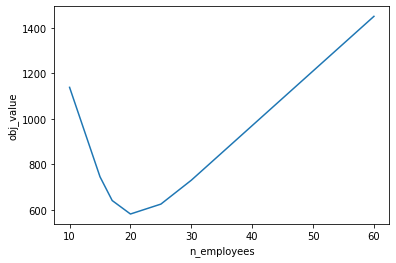

In [ ]:
sns.lineplot(data=results_df.query('region == 0'), x='n_employees', y='obj_value')
plt.show()

In [ ]:
# REGION RESULTS
region = 0
selected_areas = s.i.region_area_map[region]

region_results = results_df.query(f'region == {region}')

# OPTIMAL SOLUTION
optimal_n_employees = int(region_results.query(f'obj_value == {results_df["obj_value"].min()}')['n_employees'].values[0])

i = Instance(regions=[region], areas=areas, 
    region_area_map=region_area_map, area_region_map=area_region_map, 
    period_demands=period_demands, period_couriers=period_couriers,
    n_employees=optimal_n_employees, min_hours_worked=6*8, max_hours_worked=6*8, max_unique_starts=2,
    shifts_start=shifts_start, shifts_end=shifts_end)

s = Solver(i)
s.solve()

In [ ]:
# Area Employee assignment (for each region)
area_employee_assignment = []
for e in s.employees:
    for a in areas:
        for theta in s.Theta:
            for d in s.D:
                for p in s.shifts:
                    shift = int(s.r_var[e, p, d].X)
                value = s.k_var[e, s.i.area_region_map[a], theta, d].X
                if value > 0.5:
                    area_employee_assignment.append([e, a, theta, d, shift])

area_employee_assignment_df = pd.DataFrame(area_employee_assignment, columns=['employee', 'area', 'period', 'day', 'shift'])

In [ ]:
area_employee_assignment_df.query('employee == 0').sort_values(['day', 'period'])

,employee,area,period,day,shift
0,0,10245,2,0,1
5,0,10249,3,0,1
23,0,10369,5,0,1
15,0,10319,6,0,1
20,0,10367,2,1,1
11,0,10318,3,1,1
18,0,10365,4,1,1
12,0,10318,5,1,1
8,0,10315,2,2,1
21,0,10367,3,2,1


In [ ]:
couriers_needed_ = []
for d in s.D:
    data = (
        pd.DataFrame(s.couriers_needed[:,:,d], index=areas, columns=s.Theta).reset_index()
        .rename(columns={'index': 'area'})
        #.assign(day = d)
    )

    area_day_data = (
        pd.melt(data, id_vars=['area'], value_vars=set(data.columns).difference('area'))
        .rename(columns={'variable': 'period', 'value': 'n_couriers'})
        .assign(day = d)
    )
    couriers_needed_.append(area_day_data)

couriers_needed_df = pd.concat(couriers_needed_)

# Demand
deliveries_ = []
for d in s.D:
    data = (
        pd.DataFrame(s.deliveries[:,:,d], index=areas, columns=s.Theta).reset_index()
        .rename(columns={'index': 'area'})
        #.assign(day = d)
    )

    area_day_data = (
        pd.melt(data, id_vars=['area'], value_vars=set(data.columns).difference('area'))
        .rename(columns={'variable': 'period', 'value': 'deliveries'})
        .assign(day = d)
    )
    deliveries_.append(area_day_data)

deliveries_df = pd.concat(deliveries_)

couriers_needed_df = pd.merge(couriers_needed_df, deliveries_df, on=['area', 'period', 'day'])
couriers_needed_df.head()

# areas
area_period_days_df = (
    area_employee_assignment_df
    .groupby(['area', 'period', 'day'])
    .agg({'employee': ['count', 'unique']})
    .reset_index()
)
area_period_days_df.columns = ['area', 'period', 'day', 'employee_count', 'employees_assign']
area_period_days_df

# Outsourcing
outsourcing_shifts = []
for a in areas:
    for theta in s.Theta:
        for d in s.D:
            value = s.omega_var[s.i.area_region_map[a],theta,d].X
            #print(f'{a} {theta} {d} : {value}')
            if value > 0.0:
                outsourcing_shifts.append([a, theta, d, value])

outsourcing_shifts_df = pd.DataFrame(outsourcing_shifts, columns=['area', 'period', 'day', 'cost_outsource'])

# Join all
whole_solution_df = (
    couriers_needed_df
    # Employees
    .merge(area_period_days_df,  on=['area', 'period', 'day'], how='left')
    # Outsource
    .merge(outsourcing_shifts_df, on=['area', 'period', 'day'], how='left')
)
# DROP AREAS NOT IN REGION!!
whole_solution_df = whole_solution_df.query(f'area.isin({selected_areas})')
whole_solution_df['employee_count'].fillna(0, inplace=True)

whole_solution_df.head(30)

,area,period,n_couriers,day,deliveries,employee_count,employees_assign,cost_outsource
6,10245,0,0.0,0,0.0,0.0,NaN,NaN
7,10247,0,0.0,0,0.0,0.0,NaN,NaN
8,10249,0,0.0,0,0.0,0.0,NaN,NaN
9,10315,0,0.0,0,0.0,0.0,NaN,NaN
10,10317,0,0.0,0,0.0,0.0,NaN,NaN
11,10318,0,0.0,0,0.0,0.0,NaN,NaN
12,10319,0,0.0,0,0.0,0.0,NaN,NaN
13,10365,0,1.0,0,1.0,1.0,[10],NaN
14,10367,0,0.0,0,0.0,0.0,NaN,NaN
15,10369,0,1.0,0,1.0,2.0,"[2, 11]",NaN


In [ ]:
employees_shifts = []
for e in s.employees:
    for p in s.shifts:
        for d in s.D:
            value = s.r_var[e, p, d].X
            if value > 0.5:
                employees_shifts.append({'employee': e, 'shift': p, 'day':d, 'value': value})

employees_shifts_df = pd.DataFrame(employees_shifts)
employees_shifts_df.head()

day_employees_shifts_df = employees_shifts_df.groupby(['day', 'shift'])['value'].sum().reset_index()
day_employees_shifts_df

,day,shift,value
0,0,0,5.0
1,0,1,14.0
2,1,0,5.0
3,1,1,11.0
4,2,0,4.0
5,2,1,12.0
6,3,0,6.0
7,3,1,10.0
8,4,0,2.0
9,4,1,15.0


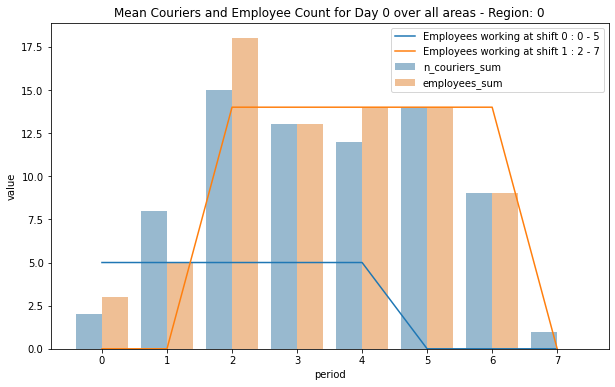

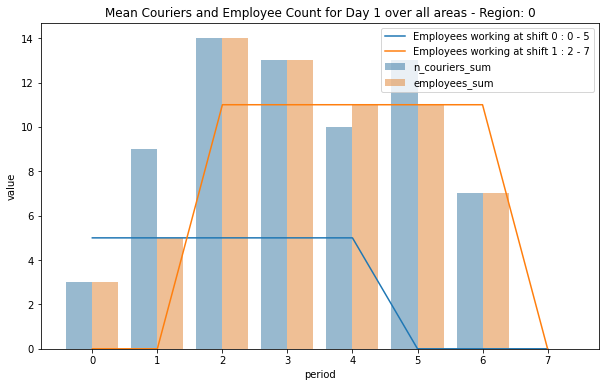

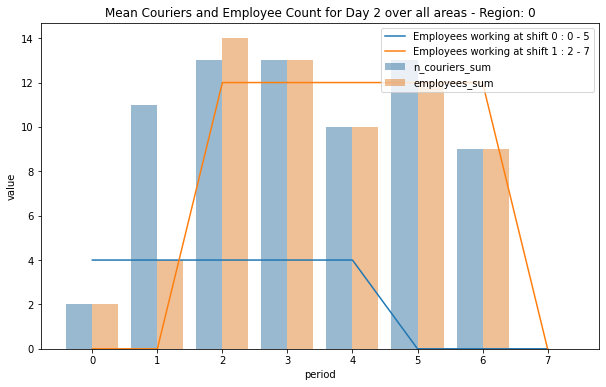

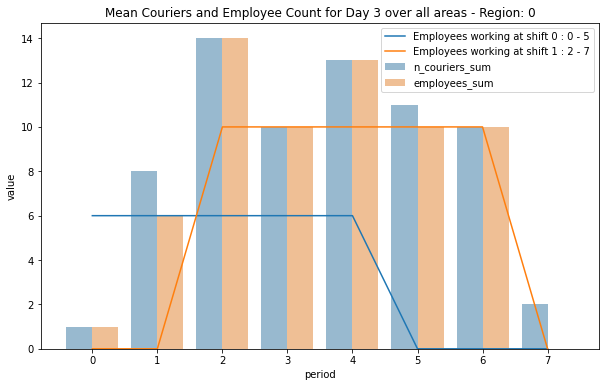

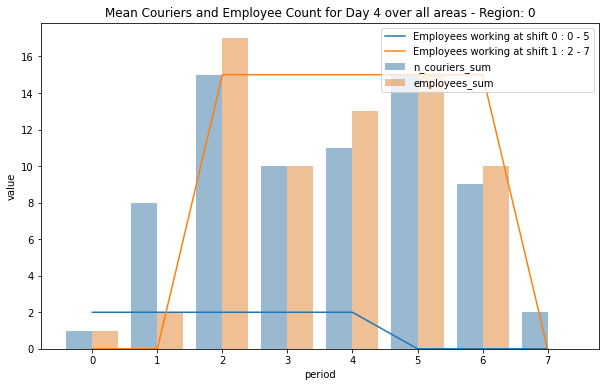

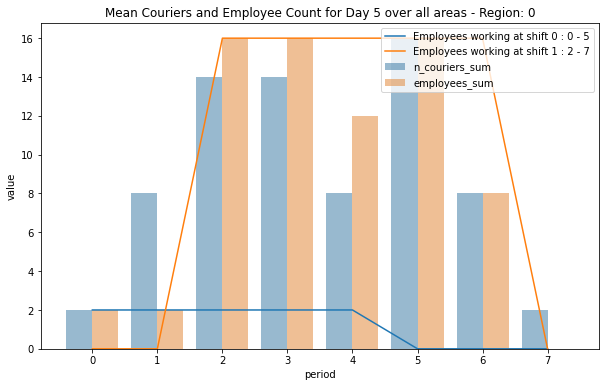

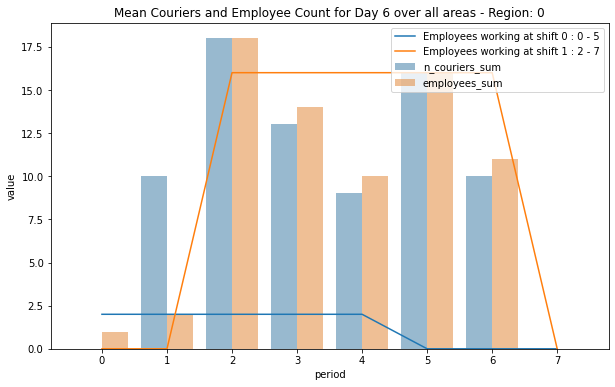

In [ ]:
for d in s.D:
    _ = whole_solution_df.query(f'day == {d}').groupby('period').agg({'n_couriers': ['sum', 'mean', 'min', 'max'], 'employee_count': ['sum', 'mean', 'min', 'max']})
    _.columns = ['n_couriers_sum', 'n_couriers_mean', 'n_couriers_min', 'n_couriers_max',
                 'employees_sum', 'employees_mean', 'employees_min', 'employees_max']
    
    a = pd.melt(_.reset_index(), id_vars='period', value_vars=['n_couriers_sum', 'employees_sum'])
    plt.figure(figsize=(10, 6))

    sns.barplot(data=a, x='period', y='value', hue='variable', alpha=0.5)

    # SHIFTS
    for key, x in s.i.shifts_start[region].items():
        start = s.i.shifts_start[region][key]
        end = s.i.shifts_end[region][key]+1
        
        workers = day_employees_shifts_df.query(f'shift == {int(key)} & day == {d}')['value'].values[0]
        #periods_ = [x for x in range(8) if i in range(start, end)]

        sns.lineplot(x=[p for p in range(8)], y=[workers if i >= start and i < end else 0 for i in range(8)], label=f'Employees working at shift {key} : {start} - {end}')

    plt.title(f"Mean Couriers and Employee Count for Day {d} over all areas - Region: {region}")  # Adding title
    plt.legend(loc='upper right')  # Displaying legend
    
    plt.show()